## Assignment Title: Fake News Detection using NLP
### Problem Statement

In the current digital era, misinformation and fake news spread rapidly on social media
and online platforms. Identifying and filtering fake news is crucial for maintaining
credible information sources.

As a data scientist working for X Social Media Analytics, your task is to develop an
NLP-based classification model to detect whether a given news article is fake or true.
You'll work with real-world datasets collected from reliable and unreliable news sources.

In [170]:
import pandas as pd
import numpy as np

import re
import nltk

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer 

stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score , classification_report #for accuracy check

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
tqdm.pandas()#enable progress_apply() in pandas

nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kapad\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Data Loading and Labeling

In [172]:
#Load both CSV files into Pandas DataFrames.
#Contains authentic news articles.

true_df = pd.read_csv("True.csv") 

In [173]:
true_df.head()

title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                text       subject  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2  WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3  WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4  SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   

                 date  
0  December 31, 2017   
1  December 29, 2017   
2  December 31, 2017   
3  December 30, 2017   
4  December 29, 2017

In [174]:
#Add a new column label: 1 for real news (True.csv)
true_df["label"] = 1 

In [175]:
true_df.head()

title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                text       subject  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2  WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3  WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4  SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   

                 date  label  
0  December 31, 2017       1  
1  December 29, 2017       1  
2  December 31, 2017       1  
3  December 30, 2017       1  
4  December 29, 2017       1

In [176]:
fake_df = pd.read_csv("Fake.csv")

In [177]:
fake_df.head()

title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   

                date  
0  December 31, 2017  
1  December 31, 2017  
2  December 30, 2017  
3  December 29, 2017  
4  December 25, 2017

In [178]:
fake_df["label"] = 0

In [179]:
fake_df.tail()

title  \
23476  McPain: John McCain Furious That Iran Treated ...   
23477  JUSTICE? Yahoo Settles E-mail Privacy Class-ac...   
23478  Sunnistan: US and Allied ‘Safe Zone’ Plan to T...   
23479  How to Blow $700 Million: Al Jazeera America F...   
23480  10 U.S. Navy Sailors Held by Iranian Military ...   

                                                    text      subject  \
23476  21st Century Wire says As 21WIRE reported earl...  Middle-east   
23477  21st Century Wire says It s a familiar theme. ...  Middle-east   
23478  Patrick Henningsen  21st Century WireRemember ...  Middle-east   
23479  21st Century Wire says Al Jazeera America will...  Middle-east   
23480  21st Century Wire says As 21WIRE predicted in ...  Middle-east   

                   date  label  
23476  January 16, 2016      0  
23477  January 16, 2016      0  
23478  January 15, 2016      0  
23479  January 14, 2016      0  
23480  January 12, 2016      0

## Understand the Data 

In [181]:
# Combine both datasets (true_df and fake_df) into one and shuffle.
news_df = pd.concat([true_df , fake_df])

In [182]:
#Drop = True: removes the old index instead of adding it as a column.
#Inplace = True: applies the change directly to your news_df
news_df.reset_index(drop =True , inplace =True)

In [183]:
# Data does not have any null values
news_df.isna().sum()

title      0
text       0
subject    0
date       0
label      0
dtype: int64

In [184]:
news_df.columns

Index(['title', 'text', 'subject', 'date', 'label'], dtype='object')

In [185]:
news_df.duplicated().sum()

209

In [186]:
news_df.drop_duplicates(inplace = True)

In [187]:
news_df

title  \
0      As U.S. budget fight looms, Republicans flip t...   
1      U.S. military to accept transgender recruits o...   
2      Senior U.S. Republican senator: 'Let Mr. Muell...   
3      FBI Russia probe helped by Australian diplomat...   
4      Trump wants Postal Service to charge 'much mor...   
...                                                  ...   
44893  McPain: John McCain Furious That Iran Treated ...   
44894  JUSTICE? Yahoo Settles E-mail Privacy Class-ac...   
44895  Sunnistan: US and Allied ‘Safe Zone’ Plan to T...   
44896  How to Blow $700 Million: Al Jazeera America F...   
44897  10 U.S. Navy Sailors Held by Iranian Military ...   

                                                    text       subject  \
0      WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1      WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2      WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3      WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4      SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   
...                                                  ...           ...   
44893  21st Century Wire says As 21WIRE reported earl...   Middle-east   
44894  21st Century Wire says It s a familiar theme. ...   Middle-east   
44895  Patrick Henningsen  21st Century WireRemember ...   Middle-east   
44896  21st Century Wire says Al Jazeera America will...   Middle-east   
44897  21st Century Wire says As 21WIRE predicted in ...   Middle-east   

                     date  label  
0      December 31, 2017       1  
1      December 29, 2017       1  
2      December 31, 2017       1  
3      December 30, 2017       1  
4      December 29, 2017       1  
...                   ...    ...  
44893    January 16, 2016      0  
44894    January 16, 2016      0  
44895    January 15, 2016      0  
44896    January 14, 2016      0  
44897    January 12, 2016      0  

[44689 rows x 5 columns]

In [188]:
news_df.shape

(44689, 5)

## Data Cleaning & Preprocessing

In [190]:
# Creating a function for data preprocessing
#(Convert into lowercase , Remove Punctuation , Numbers, HTML tags, Extra WHITESPACE)
#(Tokenize text , Remove Stopwords)
#(Apply stemming or lemmatization)
# So to complete the above tasks, we need to create a single function

def preprocess_data(data , flag):
    sentence = re.sub("[^a-zA-Z]" ," ",data) # removing special characters digits
    
    sentence = sentence.lower() # Lowercase text
    
    tokens_words = sentence.split() #token into words

    stop_words = set(stopwords.words("english"))

    clean_tokens =[token for token in tokens_words if token not in stop_words ] #remove stopwords

    if flag == "stem":
        clean_tokens = [stemmer.stem(word) for word in clean_tokens ]
    else:
        clean_tokens = [lemmatizer.lemmatize(word) for word in clean_tokens]

    preprocessed_text = " ".join(clean_tokens)
    token_count = len(clean_tokens)

    return pd.Series([preprocessed_text , token_count])

In [191]:
# lemmatization : 

In [192]:
tran_lemma = news_df["text"].progress_apply(lambda x: preprocess_data(x , "lemma"))

100%|███████████████████████████████████████████████████████████████████████████| 44689/44689 [01:11<00:00, 623.81it/s]


In [193]:
# lemmatization returns meaningful token words

In [194]:
tran_lemma.columns = ['clean_text_lemma' , 'clean_text_count']

In [195]:
news_data = pd.concat([news_df , tran_lemma], axis =1) #Clean title and merge with content

In [196]:
news_data

title  \
0      As U.S. budget fight looms, Republicans flip t...   
1      U.S. military to accept transgender recruits o...   
2      Senior U.S. Republican senator: 'Let Mr. Muell...   
3      FBI Russia probe helped by Australian diplomat...   
4      Trump wants Postal Service to charge 'much mor...   
...                                                  ...   
44893  McPain: John McCain Furious That Iran Treated ...   
44894  JUSTICE? Yahoo Settles E-mail Privacy Class-ac...   
44895  Sunnistan: US and Allied ‘Safe Zone’ Plan to T...   
44896  How to Blow $700 Million: Al Jazeera America F...   
44897  10 U.S. Navy Sailors Held by Iranian Military ...   

                                                    text       subject  \
0      WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1      WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2      WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3      WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4      SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   
...                                                  ...           ...   
44893  21st Century Wire says As 21WIRE reported earl...   Middle-east   
44894  21st Century Wire says It s a familiar theme. ...   Middle-east   
44895  Patrick Henningsen  21st Century WireRemember ...   Middle-east   
44896  21st Century Wire says Al Jazeera America will...   Middle-east   
44897  21st Century Wire says As 21WIRE predicted in ...   Middle-east   

                     date  label  \
0      December 31, 2017       1   
1      December 29, 2017       1   
2      December 31, 2017       1   
3      December 30, 2017       1   
4      December 29, 2017       1   
...                   ...    ...   
44893    January 16, 2016      0   
44894    January 16, 2016      0   
44895    January 15, 2016      0   
44896    January 14, 2016      0   
44897    January 12, 2016      0   

                                        clean_text_lemma  clean_text_count  
0      washington reuters head conservative republica...               440  
1      washington reuters transgender people allowed ...               378  
2      washington reuters special counsel investigati...               262  
3      washington reuters trump campaign adviser geor...               230  
4      seattle washington reuters president donald tr...               494  
...                                                  ...               ...  
44893  st century wire say wire reported earlier week...               319  
44894  st century wire say familiar theme whenever di...               168  
44895  patrick henningsen st century wireremember oba...              2374  
44896  st century wire say al jazeera america go hist...               275  
44897  st century wire say wire predicted new year lo...               522  

[44689 rows x 7 columns]

## Exploratory Data Analysis (EDA)


<Axes: xlabel='label', ylabel='count'>

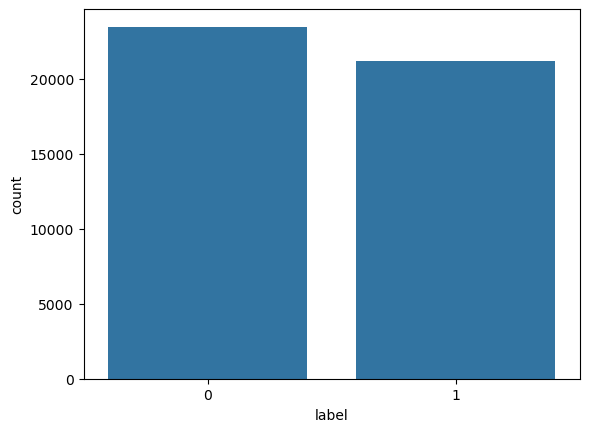

In [198]:
# Plot label distribution (Fake vs True)
sns.countplot(x = "label" ,data = news_df)

In [199]:
#Observation: In data, most of the news is fake. Above: 25000

<Axes: xlabel='subject', ylabel='count'>

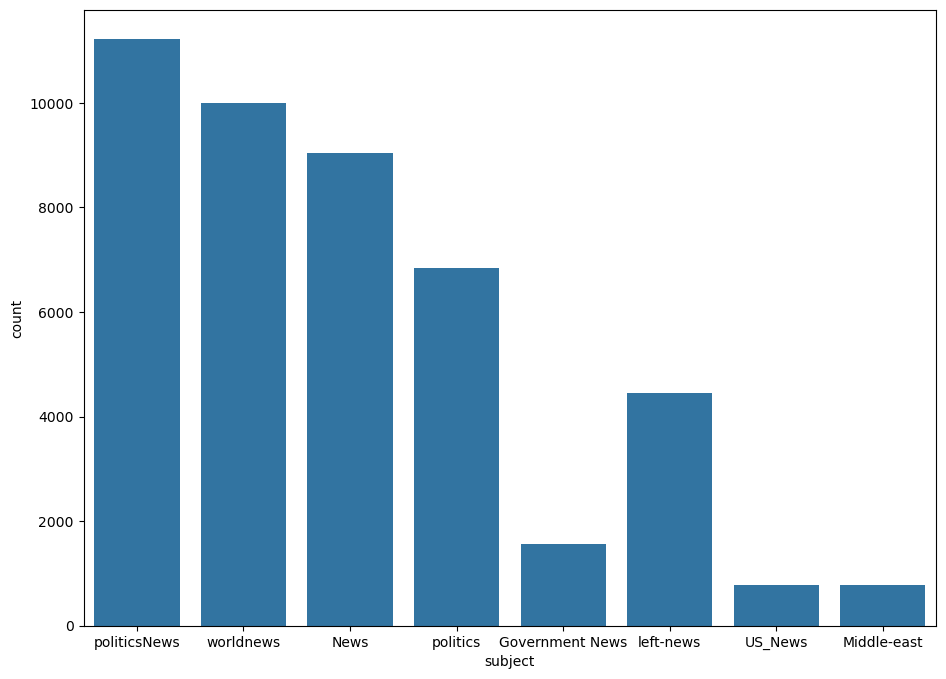

In [200]:
#Word count distribution per class
plt.figure(figsize =(11,8))
sns.countplot(x ="subject" ,data = news_data)

In [201]:
#Observation : in data most of news is about politics world news

In [202]:
news_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44689 entries, 0 to 44897
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   title             44689 non-null  object
 1   text              44689 non-null  object
 2   subject           44689 non-null  object
 3   date              44689 non-null  object
 4   label             44689 non-null  int64 
 5   clean_text_lemma  44689 non-null  object
 6   clean_text_count  44689 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 2.7+ MB


## Visualization the distribution of most frequent word

In [204]:
from collections import Counter

all_words = " ".join(news_data["clean_text_lemma"].values).split()
word_counts = Counter(all_words)

common_word = word_counts #most_common(20)
common_word = dict(common_word)
#now convert it to DataFrame
#common_word_df = pd.DataFrame(common_word , columns =["word" ,"count"])

In [205]:
common_word

{'washington': 18639,
 'reuters': 29132,
 'head': 6161,
 'conservative': 9716,
 'republican': 39622,
 'faction': 577,
 'u': 71381,
 'congress': 10162,
 'voted': 2915,
 'month': 14202,
 'huge': 1879,
 'expansion': 662,
 'national': 15846,
 'debt': 2602,
 'pay': 5162,
 'tax': 13422,
 'cut': 5181,
 'called': 13150,
 'fiscal': 1670,
 'sunday': 6124,
 'urged': 2072,
 'budget': 4649,
 'restraint': 174,
 'keeping': 1226,
 'sharp': 567,
 'pivot': 163,
 'way': 14419,
 'among': 6245,
 'representative': 6370,
 'mark': 2925,
 'meadow': 170,
 'speaking': 3704,
 'cbs': 1162,
 'face': 6158,
 'nation': 11183,
 'drew': 1239,
 'hard': 4434,
 'line': 5113,
 'federal': 11817,
 'spending': 3267,
 'lawmaker': 5932,
 'bracing': 39,
 'battle': 1955,
 'january': 5351,
 'return': 4042,
 'holiday': 776,
 'wednesday': 10005,
 'begin': 2134,
 'trying': 5671,
 'pas': 2644,
 'fight': 4609,
 'likely': 6284,
 'linked': 1270,
 'issue': 11084,
 'immigration': 6339,
 'policy': 12974,
 'even': 17967,
 'november': 4717,
 '

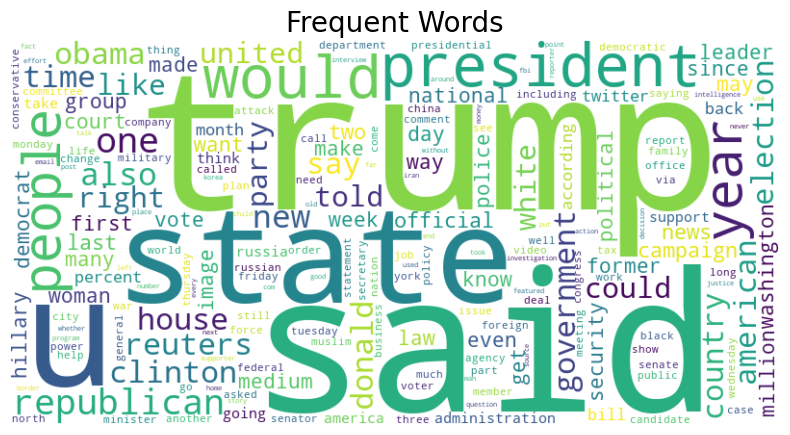

In [206]:
#Most frequent words in fake vs real news
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(common_word)

# Plot the WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Frequent Words', fontsize=20)
plt.show()

In [207]:
#Observation: the most common words in clean text are Said, Trump, U, People, year, state, would.

In [208]:
from collections import Counter

all_words = " ".join(news_data["text"].values).split()
word_counts_text = Counter(all_words)

common_word_text = word_counts_text #most_common(20)
common_word_text = dict(common_word_text)

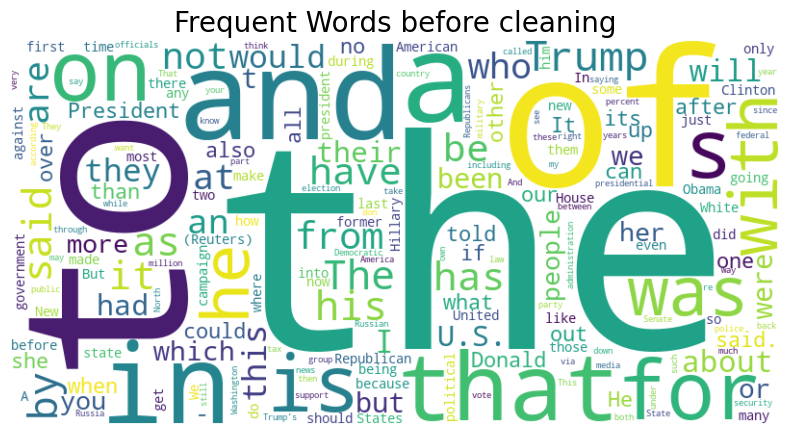

In [209]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(common_word_text)

# Plot the WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Frequent Words before cleaning', fontsize=20)
plt.show()

In [210]:
#Observation: the, to, that, and, of, was, is, this are nothing but stopwords

## Model Building:

### Data Preparation - Split the data into train and test set

In [213]:
news_data

title  \
0      As U.S. budget fight looms, Republicans flip t...   
1      U.S. military to accept transgender recruits o...   
2      Senior U.S. Republican senator: 'Let Mr. Muell...   
3      FBI Russia probe helped by Australian diplomat...   
4      Trump wants Postal Service to charge 'much mor...   
...                                                  ...   
44893  McPain: John McCain Furious That Iran Treated ...   
44894  JUSTICE? Yahoo Settles E-mail Privacy Class-ac...   
44895  Sunnistan: US and Allied ‘Safe Zone’ Plan to T...   
44896  How to Blow $700 Million: Al Jazeera America F...   
44897  10 U.S. Navy Sailors Held by Iranian Military ...   

                                                    text       subject  \
0      WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1      WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2      WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3      WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4      SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   
...                                                  ...           ...   
44893  21st Century Wire says As 21WIRE reported earl...   Middle-east   
44894  21st Century Wire says It s a familiar theme. ...   Middle-east   
44895  Patrick Henningsen  21st Century WireRemember ...   Middle-east   
44896  21st Century Wire says Al Jazeera America will...   Middle-east   
44897  21st Century Wire says As 21WIRE predicted in ...   Middle-east   

                     date  label  \
0      December 31, 2017       1   
1      December 29, 2017       1   
2      December 31, 2017       1   
3      December 30, 2017       1   
4      December 29, 2017       1   
...                   ...    ...   
44893    January 16, 2016      0   
44894    January 16, 2016      0   
44895    January 15, 2016      0   
44896    January 14, 2016      0   
44897    January 12, 2016      0   

                                        clean_text_lemma  clean_text_count  
0      washington reuters head conservative republica...               440  
1      washington reuters transgender people allowed ...               378  
2      washington reuters special counsel investigati...               262  
3      washington reuters trump campaign adviser geor...               230  
4      seattle washington reuters president donald tr...               494  
...                                                  ...               ...  
44893  st century wire say wire reported earlier week...               319  
44894  st century wire say familiar theme whenever di...               168  
44895  patrick henningsen st century wireremember oba...              2374  
44896  st century wire say al jazeera america go hist...               275  
44897  st century wire say wire predicted new year lo...               522  

[44689 rows x 7 columns]

In [214]:
y= news_data["label"]
x = news_data[["clean_text_lemma"]]

In [215]:
from sklearn.model_selection import train_test_split
x_train ,x_test ,y_train, y_test = train_test_split(x , y , test_size =0.2)

In [216]:
x_train.head(10)

clean_text_lemma
41522  one understands dirty democrat underbelly bett...
22509  news dropping supposedly trump investigation o...
13440  geneva reuters thinly veiled reference u presi...
40583  head epa president barack obama vehemently den...
13818  berlin reuters leader german chancellor angela...
2244   reuters oklahoma supreme court declared fee ci...
40792                                                   
984    new york reuters new york california democrati...
4345   washington reuters republican led senate frida...
21573  hillary clinton got fistfight jesus would want...

## Feature Extraction:

In [218]:
vocab = CountVectorizer()

X_train_bow = vocab.fit_transform(x_train['clean_text_lemma'])

In [219]:
X_train_bow

<35751x97598 sparse matrix of type '<class 'numpy.int64'>'
	with 5607312 stored elements in Compressed Sparse Row format>

In [220]:
print("Total unique words:", len(vocab.vocabulary_))

print("Type of train features:", type(X_train_bow))

print("Shape of input data:", X_train_bow.shape)

Total unique words: 97598
Type of train features: <class 'scipy.sparse._csr.csr_matrix'>
Shape of input data: (35751, 97598)


In [221]:
from sys import getsizeof

print(type(X_train_bow))
print(getsizeof(X_train_bow),"Bytes")
#This line shows how much memory (RAM) the object X_train_bow is taking up in bytes.

<class 'scipy.sparse._csr.csr_matrix'>
48 Bytes


In [222]:
X_test_bow = vocab.transform(x_test['clean_text_lemma'])

## Logistic Regression

In [224]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier.fit(X_train_bow, y_train)

LogisticRegression()

In [225]:
y_test_pred = classifier.predict(X_test_bow)

In [226]:
from sklearn.metrics import accuracy_score, classification_report

print(accuracy_score(y_test, y_test_pred))

print(classification_report(y_test, y_test_pred))

0.9961960170060417
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4726
           1       1.00      1.00      1.00      4212

    accuracy                           1.00      8938
   macro avg       1.00      1.00      1.00      8938
weighted avg       1.00      1.00      1.00      8938



## Decision Tree

In [228]:
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier()
classifier.fit(X_train_bow, y_train)

DecisionTreeClassifier()

In [229]:
y_test_pred = classifier.predict(X_test_bow)

In [230]:
from sklearn.metrics import accuracy_score, classification_report

print(accuracy_score(y_test, y_test_pred))

print(classification_report(y_test, y_test_pred))

0.9966435444170956
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4726
           1       1.00      1.00      1.00      4212

    accuracy                           1.00      8938
   macro avg       1.00      1.00      1.00      8938
weighted avg       1.00      1.00      1.00      8938



## Random Forest

In [232]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier()
classifier.fit(X_train_bow, y_train)

RandomForestClassifier()

In [233]:
y_test_pred = classifier.predict(X_test_bow)

In [234]:
from sklearn.metrics import accuracy_score, classification_report

print(accuracy_score(y_test, y_test_pred))

print(classification_report(y_test, y_test_pred))

0.9940702618035354
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      4726
           1       0.99      0.99      0.99      4212

    accuracy                           0.99      8938
   macro avg       0.99      0.99      0.99      8938
weighted avg       0.99      0.99      0.99      8938



In [295]:
#Observation: Random Forest algorithm has highest accuracy

In [297]:
from sklearn.naive_bayes import MultinomialNB 
classifier = MultinomialNB()
classifier.fit(X_train_bow ,y_train)

MultinomialNB()

In [236]:
y_test_pred = classifier.predict(X_test_bow)

In [237]:
print(accuracy_score(y_test, y_test_pred))

print(classification_report(y_test, y_test_pred))

0.9513313940478855
              precision    recall  f1-score   support

           0       0.96      0.95      0.95      4726
           1       0.95      0.95      0.95      4212

    accuracy                           0.95      8938
   macro avg       0.95      0.95      0.95      8938
weighted avg       0.95      0.95      0.95      8938

